# Exercise #4 - Deep Q Network

<img src="figures/dqn.png" width="50%" align="right"/>

Welcome to the fourth exercise in this series. In the previous exercises we worked with relatively simple environments that were solvable quickly because the number of states was limited. In this exercise we will create an agent that learns a policy for an environment with lots of states. We will still be estimating the action values, but instead of storing them in a table we will be approximating them with a neural network.

The algorithm is called "*Deep Q-learning with Experience Replay*" and the paper [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/pdf/1312.5602.pdf) describes it well. The pseudo code of the algorithm is displayed on the right.

We will implement it step-by-step.

Let's first include a number of necessities.

In [1]:
import gymnasium
import numpy as np

## Cart Pole

We will be using another Gymnasium environment, this time we will use the [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment.

In [2]:
env = gymnasium.make('CartPole-v1', render_mode='rgb_array')

## Neural network

We will use an neural network as our function approximator. There is not enough time for this course to also introduce the concepts of a neural network, so we will use an already existing implemention. It is implemented with [PyTorch](https://pytorch.org/). If you are finished early you can take a look at the implementation in the [`estimator.py`](estimator.py) file.

This neural network accepts observations from the environment as input, and will return the predicted action values for that state. I.e. it approximates the action function $q(s)$.

Let's create a new instance and see it's initial prediction.

In [3]:
from estimator import ActionValueEstimator

estimator = ActionValueEstimator(env)

# Reset the environment to get the initial observation
observation, _ = env.reset()

# Predict action value for all action in this state
action_values = estimator.predict(observation)
print(f'action values = {action_values}')

Using cuda device
action values = [ 0.10428099 -0.16754079]


You should see a list of 2 action values with random values. If you run it again the values should be different.

## $\epsilon$-greedy policy

Like in the previous exercise we will need an $\epsilon$-greedy policy to explore during training. This time the policy will be based on the output of the action value estimator model (`estimator.predict`) given an observation. Implement the **greedy** policy using and [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to select the action with the highest predicted action value. We will use a reference implementation of `epsilon_greedy_policy`, because it is the same as implemented before.

In [4]:
from utils import epsilon_greedy_policy

def greedy_policy(observation):
    global estimator
    ### START CODE ###
    # Predict actions values for the given observation
    action_values = estimator.predict(observation)
    # Determine action with the highest action value
    action = np.argmax(action_values)
    ### END CODE ###
    return action

Now let's test the implementation. We will use the same code as two cells above to get show the predicted action values for a random initial observation. The greedy policy you just implemented should return the index of the largest of the two action values. Rerun multiple times to see different random values.

In [5]:
estimator = ActionValueEstimator(env)
observation, _ = env.reset()
action_values = estimator.predict(observation)
print(f'action values = {action_values}')

action = greedy_policy(observation)
print(f'action = {action}')

action values = [ 0.10016038 -0.16217354]
action = 0


## Target action values

Training of the model will be done on batches of experience (i.e. actor-environment interactions). These batches constain:

- `observation`: The (current) observation, i.e. $S_t$
- `action`: The action taken, i.e. $A_t$
- `reward`: The reward returned by the environment after performing the action, i.e. $R_{t+1}$
- `next_observation`: The next observation after the action is performed, i.e. $S_{t+1}$
- `done`: Wheter or not the episode if finished. In other words, if the `next_observation` is of a terminal state.

From such a batch we have to compute the target values for the neural network. This means we have to compute $Q(S_t,A_t)$. Like before, we will be using the the Q-learning algorithm, so our target will be bootstrapped with the prediction of the next observation.

$$ R_t + \gamma \max_a Q(S_{t+1}, a) $$

Implement that in the following function. You have to use `estimator.predict(observations)` to get the action values for the next observations. Then use [`np.amax`](https://numpy.org/doc/stable/reference/generated/numpy.amax.html) to get the value of the action with the highest value. Make sure that you set `axis=1` to get the maximum of each sample and `keepdims=True` to keep the shapes of the arrays in order.

The value of terminal states is always 0 (remember $G_T = 0$), so $Q(S_T, a)$ must be 0 as well. You can use the `dones` array to correctly filter out those values. `dones` is an array of booleans, but similar to the C programming language you can use them as integers. A `True` value is processed as a `1` and a `False` value is processed as `0`. So, if you multiply the maximum action value (`max_next_q`) with `(1-dones)` you will end up with a valid maximum action value in samples that do not end in a terminal state, otherwise the result is 0. 

In [6]:
def compute_target_values(estimator, rewards, next_observations, dones, gamma):
    ### START CODE ###
    
    # Estimate the action values for the next observation using the prediction model.
    next_q = estimator.predict(next_observations)
    
    # Find the maximum action value.
    max_next_q = np.amax(next_q, axis=1, keepdims=True)
    
    # Compute the target action value as described above.
    # Take care of the terminal state.
    target_q = rewards + gamma * max_next_q * (1 - dones)
    
    ### END CODE ###
    return target_q

Time to test this. Run the following cell and see if your implementation is correct. A set of pre-defined input files is used to make sure the situation is always the same.

In [7]:
estimator = ActionValueEstimator(env)
estimator.load_weights('data/cartpole_test_model.pth')

r = np.load('data/cartpole_test_rewards.npy')
o = np.load('data/cartpole_test_next_observations.npy')
d = np.load('data/cartpole_test_dones.npy')
compute_target_values(estimator, r, o, d, 0.99)

array([[273.86188],
       [270.32233],
       [234.93147],
       [215.94987]], dtype=float32)

The output of this test should be exactly equal to:

    array([[273.86188],
           [270.32233],
           [234.93152],
           [215.9499 ]], dtype=float32)

Note that it's shape is `(4,1)`, i.e. a single value for each of the four samples.

If your output is not the same, then check your implementation! Make sure the shapes of the intermediate steps are correct. Check this using for instance `print(max_next_q.shape)`.

### Experience replay

As explained in the presentation, we will be using experience replay. In other words, the data gathered while interacting with the environment is stored in a big buffer with maximum capacity. From this buffer we take random batches to train on.

We will use the class `ExperienceBuffer` for this, which is implemented in the [`utils.py`](utils.py) file. If you want you can take a look how it works. It is basically a big queue of data with a maximum capacity. When new data is added the oldest data is removed/overwritten.

It has two important functions that you need to use:
- `experience_buffer.append(observation, action, reward, next_observation, done)` to append the data of a single step.
- `experience_buffer.sample(batch_size)` to get a random batch of size `batch_size`.

Let's create an instance that can store 10000 steps.

In [8]:
from utils import ExperienceBuffer
experience_buffer = ExperienceBuffer(10000, env.observation_space.shape, (1,))

## Training step

We now have nearly all the pieces in place to start training. The last missing piece is the training step itself.

The given neural network class has a dedicated function for fitting the neural network to a given dataset. It can be invoked as follows.

    estimator.train(observations, actions, values)

It uses [PyTorch](https://pytorch.org/) to automatically:
- compute the output of the network for the given input data (i.e. predict),
- compare the output with the given target values and compute a corresponding loss value,
- compute the gradients of the network weights with respect to the loss,
- update the weights of the network using an optimizer.

Each time you call `train` the estimator will change slightly toward better fitting to the given data. Each time you do this is called an epoch. In other types of machine learning you usually run multiple epochs to fit your network perfectly to the given data. For our RL problem we only want to run one epoch and then gather new data with an updated model.

We train the network on every step in the environment as long as there is data. So, let's implement an `on_step` callback function that will do the following.

1. Add the the gathered experience of this step to the buffer. (Use `experience_buffer.append`)
2. Take a random batch from the experience buffer. (Use `experience_buffer.sample`)
3. Compute the target values for the estimator using the  earlier implemented `compute_target_values()` function.
4. Call the `train` function on the estimator with the `observations`, `actions` and `target_q` as inputs.

In [9]:
def on_step(observation, action, next_observation, reward, done, length, score):
    global experience_buffer, batch_size, gamma
    ### START CODE ###

    # Add to experience buffer
    experience_buffer.append(observation, action, reward, next_observation, done)

    # Do a train step, if experience buffer contains 'batch_size' elements
    if experience_buffer.is_filled(batch_size):

        # Sample a random batch from experience
        observations, actions, rewards, next_observations, dones = experience_buffer.sample(batch_size)

        # Compute target values for batch
        target_q = compute_target_values(estimator, rewards, next_observations, dones, gamma)

        # Train the estimator to this data.
        # It needs both the `observations` and `actions` as input parameters to the neural network
        # and it needs `target_q` as target for the output of the neural network
        estimator.train(observations, actions, target_q)

    ### END CODE ###

## Training

Finally, we can implement the training loop. Let's define a number of hyperparameters for our model.

In [10]:
epsilon = 0.3
gamma = 0.99
batch_size = 256

We will again use the `run_environment` function we implemented before.

In [11]:
from utils import run_environment

Run the next cell to train for 100 episodes.
At the end the result will be saved.

In [12]:
# Start fresh
estimator = ActionValueEstimator(env)
experience_buffer.reset()

def policy(observation):
    return epsilon_greedy_policy(observation, env, greedy_policy, epsilon)

run_environment(env, 100, policy, on_step)
    
estimator.save_weights('cartpole-dqn.pth')

100%|██████████| 100/100 [00:14<00:00,  7.02it/s, avg_length=49.5, avg_score=49.5]


It finished training. By now the model should have been improved and the length and score should on average have been increasing. Time to evaluate.

## Evaluation

It took quite some time to train and that is only for a relatively small number of episodes. Let's see how well it performs anyway. Let's use the earlier implemented `evaluate` function.

In [13]:
from utils import evaluate

Let's first see how the randomly initialized model performs. It should be really bad, letting the pole drop nearly instantly.

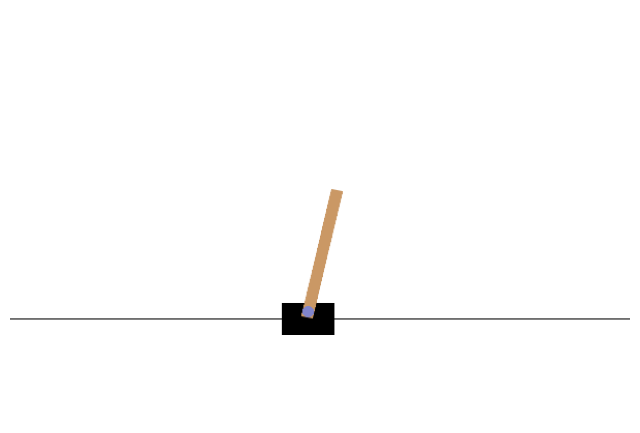

Episode length: 9, return: 9.0
initial model: 9.0


In [14]:
estimator = ActionValueEstimator(env)
length, score = evaluate(env, greedy_policy)
print(f'initial model: {score:.1f}')

Now let's see how well your trained model performs. We'll load the model as saved at the end of your training loop.

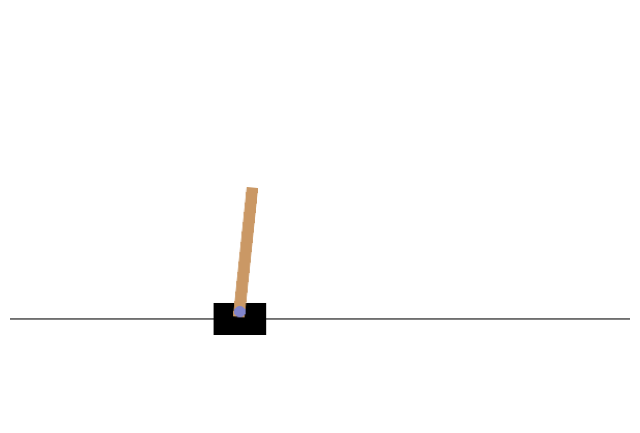

Episode length: 500, return: 500.0
partially trained model: 500.0


In [15]:
estimator.load_weights('cartpole-dqn.pth')
length, score = evaluate(env, greedy_policy)
print(f'partially trained model: {score:.1f}')

It should perform a lot better. It should no longer instantly drop the pole, but instead try to balance it. But it performs nowhere near optimal. For that we need to train it longer. Here is the performance of a model that was trained for 500 episodes. This took about 4 minutes.

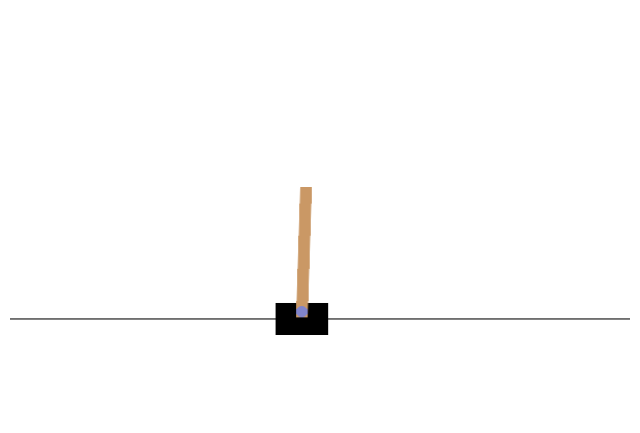

Episode length: 500, return: 500.0
fully trained model: 500.0


In [16]:
estimator.load_weights('trained/cartpole-dqn.pth')
length, score = evaluate(env, greedy_policy)
print(f'fully trained model: {score:.1f}')

## Conclusion

We have trained a model-free agent. Purely by interacting with the environment it learned what action is best for each observation it receives. It requires a lot more time and experience to train to a decent performance. But, the size of the observation is also a lot bigger than before. There are a number of things you can do to improve training time and sample efficieny (how well does it learn for a single interaction with the environment), but that's out-of-scope for this training.

In the next exercises we will implement another way to train an agent using a neural network that allows even more complex environments.

If you are interested you can also take a look at the implemention of the neural network in the [`estimator.py`](estimator.py) file.